# Entender o Problema

-- Objetivo do problema:
    -- 1.0. Previsao do primeiro destino que um novo usuário irá escolher
    
    -- Porque?
        -- Qual o tipo de modelo de negocio do Airbnb?
            -- Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
            -- Oferta (pessoas oferecendo acomodacao)
                -- Tamanho do portfolio.
                -- Diversidade/Densidade de portfolio.
                -- Preco medio
                
            -- Demanda (pessoas procurando acomodacao)
                -- Numero de usuarios
                -- LTV ( Lifetime Value )
                -- CAC ( Client Acquisition Cost )
                
                
                Gross Revenue = ( Fee*Numero clientes ) - CAC
        
-- Proposta de solucao

    --- Modelo de Predicao do primeiro destino de um novo usuario
    --- 1.0. Predicoes e salva em tabela do banco de dados
    --- 2.0. API
            --- Input: usuario e suas caracteristicas
            --- Output: usuario e suas caracteristicas com a **predicao do destino**

    --- 16 ciclos

# <font color='red'> Ciclo01: End to End </font>

# Imports

In [109]:
import pandas as pd
import random
import numpy as np
import seaborn as sns

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt
from scipy import stats as ss

from keras import models as ml
from keras import layers as l

## Helper Functions

In [90]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## Loading Data

In [91]:
df_raw = pd.read_csv( 'dataset/training_users.csv', low_memory=True )
df_raw.shape

(213451, 16)

In [92]:
df_sessions = pd.read_csv( 'dataset/sessions.csv', low_memory=True )
df_sessions.shape

(10567737, 6)

# Data Description

In [93]:
df1 = df_raw.copy()

## Data Dimensions

In [94]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columss: {}'.format( df1.shape[1] ) )

Number of rows: 213451
Number of columss: 16


In [95]:
print( 'Number of rows: {}'.format( df_sessions.shape[0] ) )
print( 'Number of columss: {}'.format( df_sessions.shape[1] ) )

Number of rows: 10567737
Number of columss: 6


## Data Type

In [96]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [97]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## NA check

In [98]:
df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [99]:
df_sessions.isna().sum() / len( df_sessions )

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [100]:
# remove missing value completly
# df1 = df1.dropna()

# ================= User =================
# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )

# age
avg_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ================= Sessions =============
# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## Change Data Type

In [101]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [102]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype( int )

## Check Balanced Data

In [103]:
df1['country_destination'].value_counts( normalize=True )

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## Descriptive Analysis

In [104]:
# Users
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int64', 'float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'])

### Numerical - Users

In [105]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543915,2.287158,3.567794


### Numerical - Sessions

In [106]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_sessions.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply( np.std )).T
d2 = pd.DataFrame( num_attributes_sessions.apply( min )).T
d3 = pd.DataFrame( num_attributes_sessions.apply( max )).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.kurtosis() )).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### Categorical - Users

In [107]:
cat_attributes.drop( 'id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


### Categorical - Session

In [114]:
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [111]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range( len( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        ## correlation
        corr = cramer_v( cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ])
        
        # append a list
        corr_list.append( corr )
        
    # append a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

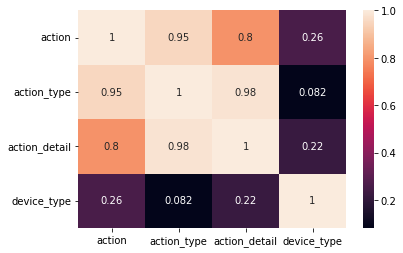

In [112]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )
sns.heatmap( d, annot=True)

# Feature Engineering

In [115]:
df2 = df1.copy()

In [116]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Create New Features

In [125]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime('%Y-%m-%d') )
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply( lambda x: x.days)

# days from first active up to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply( lambda x: x.days)


# days from account created up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply( lambda x: x.days)

# ================= First active ===============
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_first_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================= First Booking ===============
# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================= Account Created ===============
# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month first booking
df2['month_account_created'] = df2['date_account_created'].dt.month

# day first booking
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week first booking
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year first booking
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

/tmp/ipykernel_267809/2124150632.py:26: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
/tmp/ipykernel_267809/2124150632.py:42: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
/tmp/ipykernel_267809/2124150632.py:58: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [126]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,49,facebook,0,en,direct,...,2015,6,29,0,27,2010,6,28,0,26
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,...,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,...,2010,2,18,3,7,2010,9,14,1,37


In [127]:
df2.dtypes

id                                                       object
date_account_created                             datetime64[ns]
timestamp_first_active                           datetime64[ns]
date_first_booking                               datetime64[ns]
gender                                                   object
age                                                       int64
signup_method                                            object
signup_flow                                               int64
language                                                 object
affiliate_channel                                        object
affiliate_provider                                       object
first_affiliate_tracked                                  object
signup_app                                               object
first_device_type                                        object
first_browser                                            object
country_destination                     

# Data Filtering

In [128]:
df3 = df2.copy()

## Filtering Rows

In [129]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 120 years old
df3 = df3[(df3['age'] > 15) & (df3['age'] < 120 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
# df3 = df3[df3['secs_elapsed'] > 0]

## Columns Selection

# Data Preparation

In [131]:
df4 = df3.copy()

In [132]:
# dummy variable
df4_dummy = pd.get_dummies( df4.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df4 = pd.concat( [df4[['id', 'country_destination']], df4_dummy], axis=1 )

In [133]:
df4.shape

(206593, 156)

# Feature Selection

In [134]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # original dates
df5 = df4.drop( cols_drop, axis=1 )

In [137]:
X = df5.drop( 'country_destination', axis=1 )
y = df5['country_destination'].copy()

In [138]:
x_train, x_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

# Machine Learning Model

In [139]:
x_train = x_train.drop( 'id', axis=1 )
x_test = x_test.drop( 'id', axis=1 )

## Baseline Model

In [140]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

yhat_random = random.choices( population=country_destination_list, 
                             weights=country_destination_weights, 
                             k=k_num)
len( yhat_random )

41319

Accuracy: 0.4277693070984293
Balanced Accuracy:1.0
Kappa Score: 0.0024089835486456046
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       265
          DE       0.00      0.00      0.00       234
          ES       0.01      0.01      0.01       385
          FR       0.03      0.03      0.03       971
          GB       0.02      0.02      0.02       457
          IT       0.01      0.01      0.01       553
         NDF       0.58      0.58      0.58     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.30      0.30      0.30     12249
       other       0.05      0.05      0.05      1980

    accuracy                           0.43     41319
   macro avg       0.08      0.08      0.08     41319
weighted avg       0.43      0.43      0.43     41319



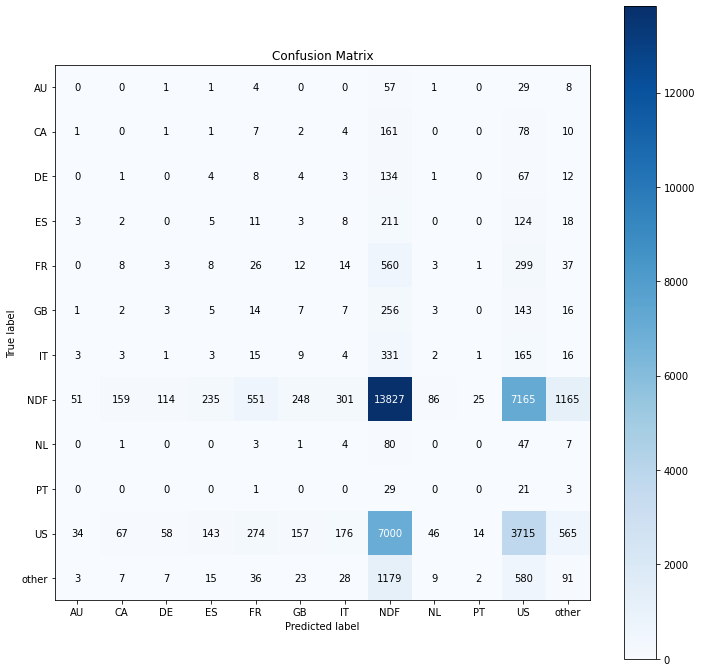

In [141]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print('Accuracy: {}'.format( acc_random) )

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score( yhat_random, yhat_random )
print( 'Balanced Accuracy:{}'.format( balanced_acc_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification report
print( m.classification_report( y_test, yhat_random) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12) );

## Neural Network - MLP

In [142]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [144]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
5165/5165 [==============================] - 11s 2ms/step - loss: 4.5216 - accuracy: 0.7928
Epoch 2/100
5165/5165 [==============================] - 11s 2ms/step - loss: 1.1696 - accuracy: 0.8232
Epoch 3/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.6433 - accuracy: 0.8548
Epoch 4/100
5165/5165 [==============================] - 11s 2ms/step - loss: 0.5269 - accuracy: 0.8707
Epoch 5/100
5165/5165 [==============================] - 11s 2ms/step - loss: 0.4999 - accuracy: 0.8730
Epoch 6/100
5165/5165 [==============================] - 13s 2ms/step - loss: 0.4979 - accuracy: 0.8732
Epoch 7/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.4983 - accuracy: 0.8731
Epoch 8/100
5165/5165 [==============================] - 11s 2ms/step - loss: 0.4969 - accuracy: 0.8732
Epoch 9/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.4963 - accuracy: 0.8734
Epoch 10/100
5165/5165 [==============================] - 8s 2ms

5165/5165 [==============================] - 8s 1ms/step - loss: 0.4910 - accuracy: 0.8737
Epoch 80/100
5165/5165 [==============================] - 6s 1ms/step - loss: 0.4906 - accuracy: 0.8738
Epoch 81/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4919 - accuracy: 0.8736
Epoch 82/100
5165/5165 [==============================] - 8s 2ms/step - loss: 0.4905 - accuracy: 0.8737
Epoch 83/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4907 - accuracy: 0.8738
Epoch 84/100
5165/5165 [==============================] - 6s 1ms/step - loss: 0.4908 - accuracy: 0.8737
Epoch 85/100
5165/5165 [==============================] - 6s 1ms/step - loss: 0.4908 - accuracy: 0.8737
Epoch 86/100
5165/5165 [==============================] - 12s 2ms/step - loss: 0.4907 - accuracy: 0.8737
Epoch 87/100
5165/5165 [==============================] - 15s 3ms/step - loss: 0.4910 - accuracy: 0.8737
Epoch 88/100
5165/5165 [==============================] - 13s 3ms/step - lo

# NN Performance

In [145]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

Accuracy: 0.8754084077543018
Balanced Accuracy:0.16663265028437696
Kappa Score: 0.7692081102960318


/home/lucas/.pyenv/versions/3.8.0/envs/airbnbfirstbooking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lucas/.pyenv/versions/3.8.0/envs/airbnbfirstbooking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lucas/.pyenv/versions/3.8.0/envs/airbnbfirstbooking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       265
          DE       0.00      0.00      0.00       234
          ES       0.00      0.00      0.00       385
          FR       0.00      0.00      0.00       971
          GB       0.00      0.00      0.00       457
          IT       0.00      0.00      0.00       553
         NDF       1.00      1.00      1.00     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.70      1.00      0.83     12249
       other       0.00      0.00      0.00      1980

    accuracy                           0.88     41319
   macro avg       0.14      0.17      0.15     41319
weighted avg       0.79      0.88      0.82     41319



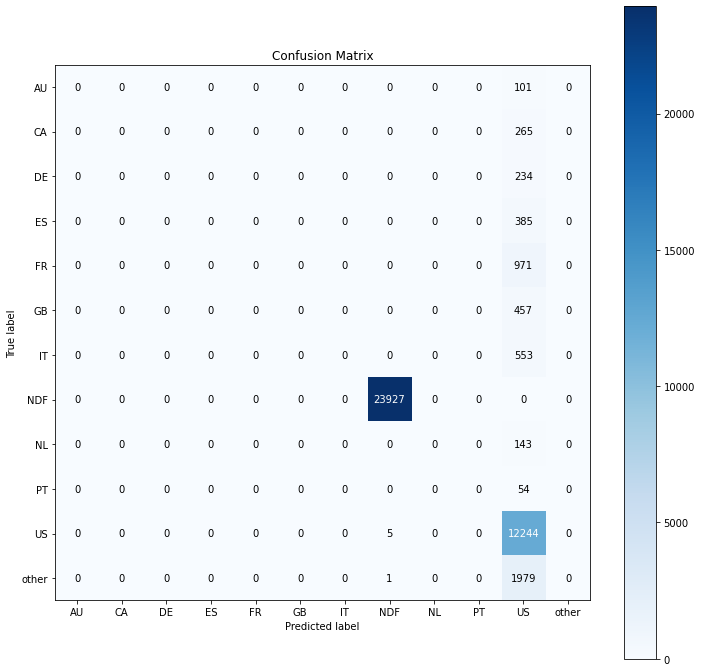

In [146]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print('Accuracy: {}'.format( acc_nn) )

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy:{}'.format( balanced_acc_nn ) )

# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# Classification report
print( m.classification_report( y_test_nn, yhat_nn) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12) );

### NN Performance - Cross-validation

In [28]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [37]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.mean( balanced_acc_list ), np.std( balanced_acc_list ) ) )
print( 'Avg Kappa: {} +/- {}'.format( np.mean( kappa_acc_list ), np.std( kappa_acc_list ) ) )

Avg Balanced Accuracy: 0.09170340864570534 +/- 0.0006935621393682294
Avg Kappa: 0.003889496235490353 +/- 0.0019405754097840944
